In [43]:
from langchain_ollama import OllamaEmbeddings, ChatOllama
import numpy as np
from pydantic import BaseModel, Field


In [116]:
embeddings = OllamaEmbeddings(
    model="qwen3-embedding",
    base_url="http://100.91.155.118:11434",
)
llm = ChatOllama(
    model="gemma3:27b",
    base_url="http://100.91.155.118:11434",
    temperature=0.7,
)

In [127]:
class ReferenceResponse(BaseModel):
    likert_1: str = Field(..., description="A response that strongly disagrees with the statement.")
    likert_2: str = Field(..., description="A response that disagrees with the statement.")
    likert_3: str = Field(..., description="A response that neither agrees nor disagrees with the statement.")
    likert_4: str = Field(..., description="A response that agrees with the statement.")
    likert_5: str = Field(..., description="A response that strongly agrees with the statement.")

In [128]:
structured_llm = llm.with_structured_output(ReferenceResponse)

In [129]:
reference = structured_llm.invoke([
    {"role": "system", "content": "You are an expert survey designer. Provide reference responses for Likert scale survey questions, ranging from strongly disagree to strongly agree. Ensure the responses are clear and concise, suitable for a general audience but avoid overly simplistic language."},
    {"role": "user", "content": "Provide example responses for the following statement: 'How likely are you to purchase our new product?'"},
])

In [137]:
def reference_embeddings(reference: ReferenceResponse):
    embedding_1 = np.array(embeddings.embed_query(reference.likert_1))
    embedding_2 = np.array(embeddings.embed_query(reference.likert_2))
    embedding_3 = np.array(embeddings.embed_query(reference.likert_3))
    embedding_4 = np.array(embeddings.embed_query(reference.likert_4))
    embedding_5 = np.array(embeddings.embed_query(reference.likert_5))

    return {
        "1": embedding_1,
        "2": embedding_2,
        "3": embedding_3,
        "4": embedding_4,
        "5": embedding_5
    }

In [138]:
LIKERT_SCALE = reference_embeddings(reference)

In [159]:
np.linalg.norm(LIKERT_SCALE['5'])

np.float64(0.9999999009272986)

In [139]:
def get_weighted_likert_vector(query: str) -> np.ndarray:

    embed = np.array(embeddings.embed_query(query))

    scale = {}
    for rating, vector in LIKERT_SCALE.items():
        similarity = (1 + np.dot(embed, vector) / (np.linalg.norm(embed) * np.linalg.norm(vector))) / 2  # Normalize to [0, 1]
        scale[rating] = similarity
    min_similarity = min(scale.values())
    for rating in scale:
        scale[rating] -= min_similarity  # Shift to make minimum 0
    total_similarity = sum(scale.values())
    
    for rating in scale:
        scale[rating] /= total_similarity
    return scale
        

In [140]:
def response_embeddings_to_pmf(matrix_responses, matrix_likert_sentences, epsilon=0.0):
    """
    Convert response embeddings and Likert sentence embeddings to a PMF.

    Parameters
    ----------
    matrix_responses : array_like
        Matrix of response embeddings
    matrix_likert_sentences : array_like
        Matrix of Likert sentence embeddings
    epsilon : float, optional
        Small regularization parameter to prevent division by zero and add smoothing.
        Default is 0.0 (no regularization).

    Returns
    -------
    numpy.ndarray
        Probability density function representing the response distribution

    Notes
    -----
    This implements the SSR equation:
    p_{c,i}(r) = [γ(σ_{r,i}, t_c̃) - γ(σ_ℓ,i, t_c̃) + ε δ_ℓ,r] /
                 [Σ_r γ(σ_{r,i}, t_c̃) - n_points * γ(σ_ℓ,i, t_c̃) + ε]
    where γ is the cosine similarity function, δ_ℓ,r is the Kronecker delta,
    and n_points is the number of Likert scale points.
    """
    M_left = matrix_responses
    M_right = matrix_likert_sentences

    # Handle empty input case
    if M_left.shape[0] == 0:
        return np.empty((0, M_right.shape[1]))

    # Normalize the right matrix (Likert sentences)
    norm_right = np.linalg.norm(M_right, axis=0)
    M_right = M_right / norm_right[None, :]

    # Normalize the left matrix (responses)
    norm_left = np.linalg.norm(M_left, axis=1)
    M_left = M_left / norm_left[:, None]

    # Calculate cosine similarities: γ(σ_{r,i}, t_c̃)
    cos = (1 + M_left.dot(M_right)) / 2

    # Find minimum similarity per row: γ(σ_ℓ,i, t_c̃)
    cos_min = cos.min(axis=1)[:, None]

    # Numerator: γ(σ_{r,i}, t_c̃) - γ(σ_ℓ,i, t_c̃) + ε δ_ℓ,r
    # The ε δ_ℓ,r term adds epsilon only to exactly one minimum similarity position per row
    numerator = cos - cos_min
    if epsilon > 0:
        # Add epsilon to the first position that achieves minimum in each row (Kronecker delta effect)
        min_indices = np.argmin(cos, axis=1)
        for i, min_idx in enumerate(min_indices):
            numerator[i, min_idx] += epsilon

    # Denominator: Σ_r γ(σ_{r,i}, t_c̃) - n_likert_points * γ(σ_ℓ,i, t_c̃) + ε
    # This is: sum of all similarities - n_likert_points * minimum similarity + epsilon
    n_likert_points = cos.shape[1]
    denominator = cos.sum(axis=1)[:, None] - n_likert_points * cos_min + epsilon

    # Calculate final PMF
    pmf = numerator / denominator

    return pmf

In [145]:
content = llm.invoke([
    {"role": "system", "content": "You are a middle-aged white man working a retail job who lives in a city. Provide a response to the survey for a new gardening product that helps make caring for plants easier in confined spaces."},
    {"role": "user", "content": "'How likely are you to purchase our new product?'"},
])

In [153]:
reference

ReferenceResponse(likert_1='I am highly unlikely to purchase this product at this time, and currently have no intention of doing so.', likert_2='I am quite unlikely to purchase this product, though I might consider it under specific, highly favorable conditions.', likert_3='I am neutral regarding a potential purchase; I require more information or am undecided about its value to me.', likert_4='I am somewhat likely to purchase this product, potentially if it meets my needs and budget expectations.', likert_5='I am very likely to purchase this product; I anticipate it will be a valuable addition and I intend to make a purchase.')

In [165]:
content.content[76:]

'Honestly? Probably a **6 out of 10**. Look, I live in the city, right? Small apartment. Balcony\'s barely big enough for a chair, let alone a garden. I *wish* I had a green thumb, I really do. My grandmother had the most beautiful roses, but I... well, I kill cacti. It\'s a talent.\n\nSo, the idea of something that makes it *easier* to grow stuff in a small space is appealing. I\'ve thought about getting some herbs, maybe a little tomato plant, just to brighten things up. But I always talk myself out of it because I figure I\'ll forget to water it or something, and then it\'ll be a sad, droopy mess. \n\nIf this product genuinely simplifies things – like, really simplifies – then yeah, I could see myself giving it a shot. But I\'d need to know *how* easy. Is it self-watering? Does it tell me when to fertilize? Does it need a ton of sunlight? I\'m skeptical, honestly. I\'ve bought "easy care" plants before that weren\'t. \n\nSo, 6 out of 10. Show me it actually works, and you might get 

In [172]:
embeddings_matrix = np.array([embeddings.embed_query("6 out of 10. Show me it actually works, and you might get a sale.") for i in range(1, 2)])
pmf = response_embeddings_to_pmf(embeddings_matrix, np.array(list(LIKERT_SCALE.values())).T, epsilon=1e-6)

In [173]:
import matplotlib.pyplot as plt

<BarContainer object of 5 artists>

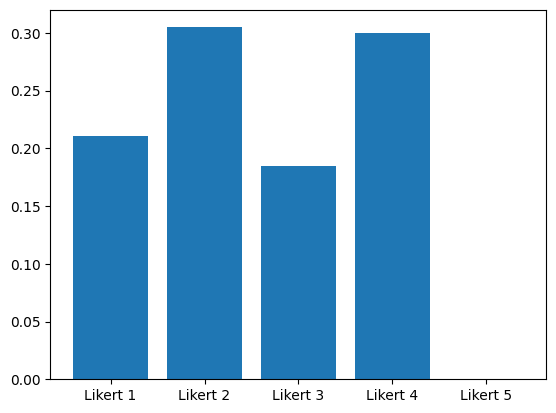

In [174]:
plt.bar([f'Likert {i}' for i in range(1, 6)], pmf[0])

In [143]:
reference

ReferenceResponse(likert_1='I am highly unlikely to purchase this product at this time, and currently have no intention of doing so.', likert_2='I am quite unlikely to purchase this product, though I might consider it under specific, highly favorable conditions.', likert_3='I am neutral regarding a potential purchase; I require more information or am undecided about its value to me.', likert_4='I am somewhat likely to purchase this product, potentially if it meets my needs and budget expectations.', likert_5='I am very likely to purchase this product; I anticipate it will be a valuable addition and I intend to make a purchase.')